In [1]:
%load_ext autoreload
%autoreload 2

In [129]:
from tf.app import use
A = use("ETCBC/dss", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


In [130]:
from tqdm import tqdm
import re
import pandas as pd
import matplotlib.pyplot as plt
chars_to_delete = re.compile("[\\\\\^><»≥≤/?Ø\\]\\[«|}{]")
def get_biblical_from_line(line):
    """
    Returns the biblical section of a line.
    """
    bib = F.biblical.v(line)
    if bib == None:
        return 'nonbib'
    elif bib == 1:
        return 'bib'
    elif bib == 2:
        return 'biblical_non_biblical'

def remove_chars(s):
    chars_to_delete = "#ε^><»≥≤/?Ø«|}{׳"
    for char in chars_to_delete:
        s = s.replace(char, "")
    return s


In [131]:

data = {}
books = {}
for line in tqdm(F.otype.s("line")[:]):
    book_and_chapter = A.sectionStrFromNode(line)
    book = A.sectionStrFromNode(line).split(" ")[0]
    text = book_and_chapter + "\t" + str(get_biblical_from_line(line)) + "\t"+ T.text(line)
    text = remove_chars(text).replace("\xa0", "").replace("׃",".")
    text = [text]
    if book not in data:
        data[book] = [text]
    else: 
        data[book].append(text)


100%|██████████| 52895/52895 [00:05<00:00, 9054.86it/s] 


In [132]:
from notebooks.utils import write_data, parse_data, generate_stats,plot_word_line_stats

# write_data(data,"all_data.txt")
df = parse_data(data)
book_stats, label_stats = generate_stats(df)


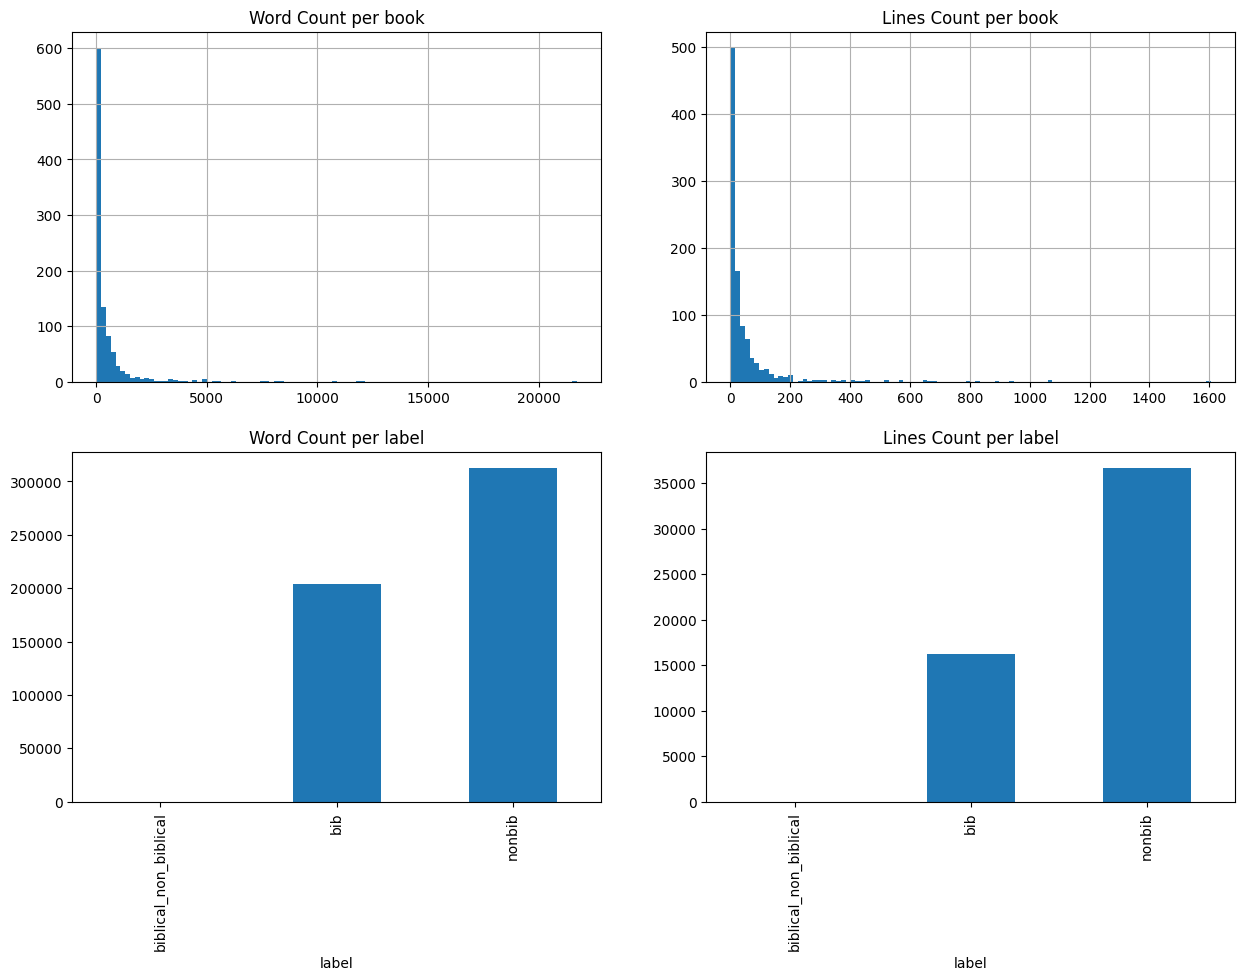

In [133]:
plot_word_line_stats(book_stats, label_stats)

In [139]:

from notebooks.utils import data_cleaning

df_filtered = data_cleaning(df, book_stats)

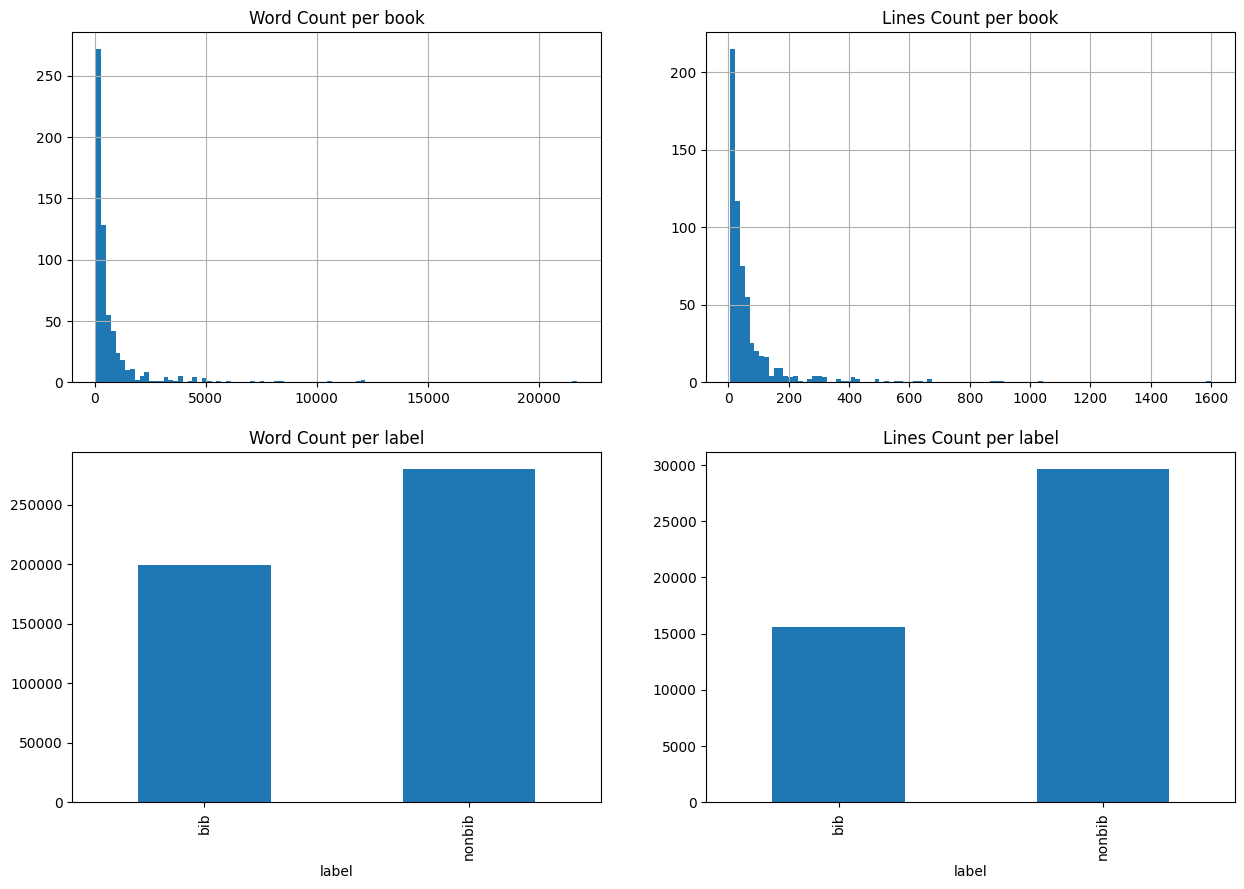

In [140]:
book_stats, label_stats = generate_stats(df_filtered)
plot_word_line_stats(book_stats, label_stats)

In [141]:
df_by_book = df_filtered.groupby("book")["text"].apply(list).str.join(" ").str.replace("/", "")
book_to_label = df_filtered.groupby("book")["label"].value_counts().reset_index().drop_duplicates("book")[["book", "label"]]
df_filtered = pd.merge(book_to_label, df_by_book, on="book")


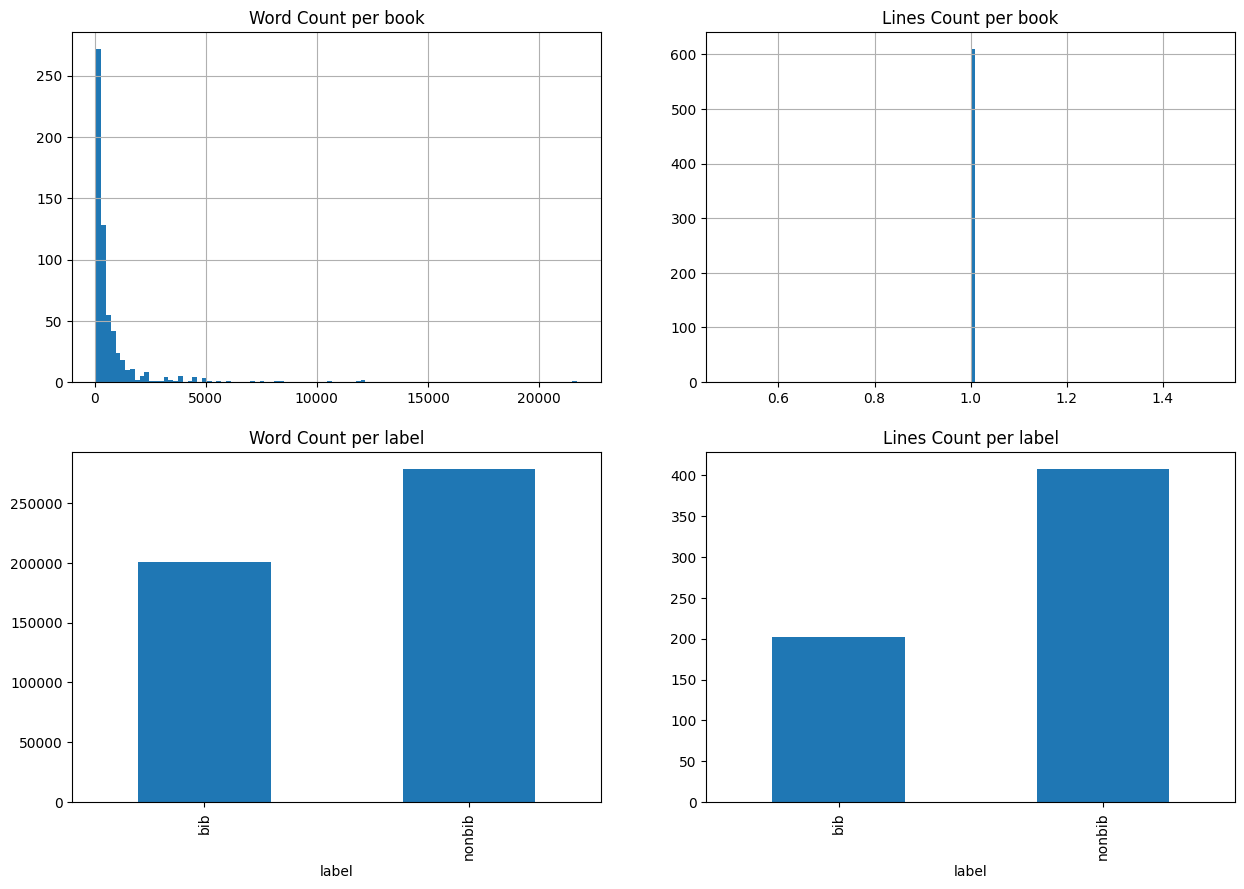

In [142]:
book_stats, label_stats = generate_stats(df_filtered)
plot_word_line_stats(book_stats, label_stats)

In [138]:
import re

def preprocess(text):
    # Normalize and replace newlines and carriage returns with space
    text = text.replace('\n', ' ').replace('\r', ' ')
    # Filter out everything except basic Hebrew letters (א-ת)
    text = re.sub('[^\u05D0-\u05EA ]+', '', text)
    # Optional: Remove multiple spaces
    text = ' '.join(text.split())
    return text

# Apply the preprocessing to your dataframe
df_filtered['text'] = df_filtered['text'].apply(preprocess)

In [65]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_filtered, test_size=0.3, random_state=42, stratify=df_filtered["label"])
df_train["train_test"]="train"
df_test["train_test"]="test"
df_filtered = pd.concat([df_train, df_test])

In [73]:
df_filtered.groupby(["train_test","label"]).count()

book  text
train_test label             
test       bib       61    61
           nonbib   122   122
train      bib      141   141
           nonbib   286   286

In [74]:
# df_filtered[["book_pasuk", "train_test", "label"]].to_csv(
#         f"DSS_bibnobib_tf_labels.txt",
#         sep="\t",
#         index=False,
#         header=False,
#     )
# 
# df_filtered["text"].to_csv(
#         f"DSS_bibnobib_tf_text.txt", index=False, header=False
#     )

In [113]:
def get_tf_idf_features(df):
    from sklearn.feature_extraction.text import TfidfVectorizer
    td = TfidfVectorizer(max_features = 4500)
    X = df["text"]
    y = df["label"]
    X = td.fit_transform(X).toarray()
    return X, y
        
def get_trigram_features(df):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer_trigram = CountVectorizer(analyzer='char', ngram_range=(3,3))
    X = vectorizer_trigram.fit_transform(df["text"])
    y = df["label"]
    return X, y

def training(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)
    classifier = model()
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    # Classification metrics
    
    classification_report_print = classification_report(y_test, y_pred)
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)

    
    # print('\n Accuracy: ', accuracy_score(y_test, y_pred))
    # print('\nClassification Report')
    # print('======================================================')
    # print('\n', classification_report_print)
    return classification_report_dict
def gather_stats(output_iter, method):
    res = []
    for label in ['bib', 'nonbib']:

        precision = output_iter[label]["precision"]
        recall = output_iter[label]["recall"]
        f1 = output_iter[label]["f1-score"]
        res.append({"method": method,"label": label, "precision": precision, "recall": recall, "f1": f1})
    accuracy = {"method": method, 'accuracy': output_iter["accuracy"]}
    return res, accuracy


In [114]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
precision_recall = []
accuracy = []
for iter in range(3):
    X1,y1 = get_tf_idf_features(df_filtered)
    output_iter = training(X1,y1,MultinomialNB)
    res1, accuracy1 = gather_stats(output_iter, "tf-idf")
    
    X2,y2 = get_trigram_features(df_filtered)
    output_iter = training(X2,y2,MultinomialNB)
    res2, accuracy2 = gather_stats(output_iter, "trigram")
    
    precision_recall.extend(res1)
    precision_recall.extend(res2)
    accuracy.extend(res1)
    accuracy.extend(res2)


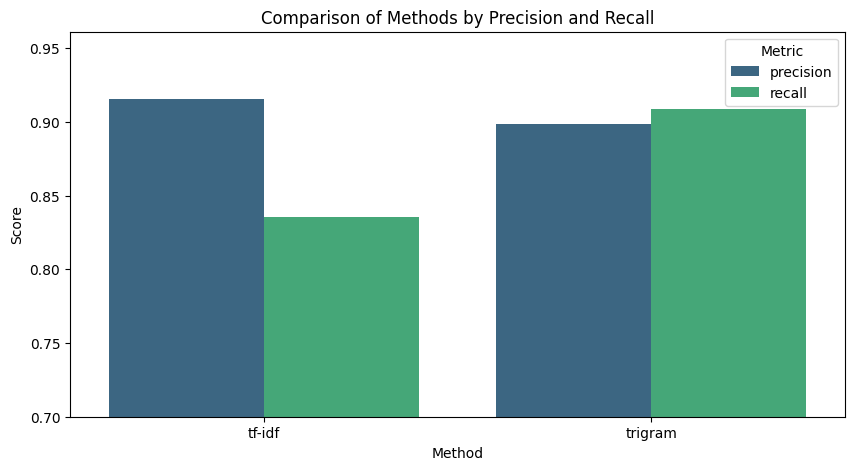

In [126]:
import seaborn as sns
comparison_results = pd.DataFrame(precision_recall)

avg_metrics = comparison_results.groupby('method')[['precision', 'recall']].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 5))

# Plot for Precision and Recall by Method
sns.barplot(x='method', y='value', hue='variable', data=pd.melt(avg_metrics, id_vars=['method']), palette='viridis')
plt.title('Comparison by Precision and Recall (naive bayes)')
plt.ylabel('Score')
plt.xlabel('Method')
plt.legend(title='Metric')
plt.ylim(0.7,)
plt.show()